In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):     
    for filename in filenames:
         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Ensure necessary packages are installed (Kaggle usually has them, but good practice)
# pip install tensorflow scikit-learn matplotlib numpy opencv-python nibabel tqdm # Redundant if running in Kaggle default env

import nibabel as nib
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/MANDATORY_CITATION.md
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/MANDATORY_CITATION.md
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/patient007_4d.nii
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/Info.cfg
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/patient007_frame01_gt.nii
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/MANDATORY_CITATION.md
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/patient007_frame07.nii
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/patient007_frame01.nii
/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training/patient007/patient007_frame07_gt.nii
/kaggle/input/automated-cardia

2025-07-08 14:34:21.226260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751985261.576719      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751985261.675689      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# ----------------------------
# CONFIG
# ----------------------------
IMG_SIZE = (128, 128)
NUM_CLASSES = 4 # 0: Background, 1: RV, 2: Myo, 3: LV
BATCH_SIZE = 8 # Adjust based on GPU memory and dataset size
EPOCHS = 100 # Start with a higher number, EarlyStopping will prevent overfitting

# Path to your data - ENSURE THIS IS CORRECT FOR YOUR KAGGLE SETUP
data_dir = '/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training'
# data_dir = '../input/automated-cardiac-diagnosis-challenge-miccai17/database/training' # Alternative common path

# Threshold for filtering slices: minimum percentage of foreground pixels
# A slice must have at least this percentage of non-background pixels to be included.
# This helps to filter out slices that are almost entirely background or outside the heart region.
MIN_FOREGROUND_PERCENTAGE = 0.0001 # e.g., 1% of pixels must be foreground (class 1, 2, or 3)

In [13]:
# ----------------------------
# LOAD AND PREPROCESS ALL RELEVANT SLICES FROM NIFTI FILES
# ----------------------------
def load_and_preprocess_all_slices(data_dir, img_size, num_classes, min_foreground_percentage):
    X_slices, Y_slices = [], []
    
    if not os.path.exists(data_dir):
        print(f"ERROR: Data directory does not exist: {data_dir}")
        return np.array(X_slices), np.array(Y_slices)
        
    patient_dirs_all = os.listdir(data_dir)
    patient_dirs = sorted([d for d in patient_dirs_all if d.startswith("patient") and os.path.isdir(os.path.join(data_dir, d))])

    print(f"Found {len(patient_dirs_all)} total items in data_dir.")
    print(f"Found {len(patient_dirs)} potential patient directories (starting with 'patient' and are directories).")

    if not patient_dirs:
        print(f"ERROR: No patient directories found in {data_dir}. Please check the path and directory structure.")
        return np.array(X_slices), np.array(Y_slices)

    processed_patient_count = 0
    for patient_idx, patient in enumerate(tqdm(patient_dirs, desc="Processing Patients")):
        path = os.path.join(data_dir, patient)
        
        # Try both .nii.gz and .nii extensions
        frame_id = "frame01" # Focus on one frame for now to simplify
        img_nifti_path_gz = os.path.join(path, f"{patient}_{frame_id}.nii.gz")
        mask_nifti_path_gz = os.path.join(path, f"{patient}_{frame_id}_gt.nii.gz")
        img_nifti_path_nii = os.path.join(path, f"{patient}_{frame_id}.nii")
        mask_nifti_path_nii = os.path.join(path, f"{patient}_{frame_id}_gt.nii")

        img_nifti_path = None
        mask_nifti_path = None

        if os.path.exists(img_nifti_path_gz):
            img_nifti_path = img_nifti_path_gz
        elif os.path.exists(img_nifti_path_nii):
            img_nifti_path = img_nifti_path_nii
        else:
            # print(f"Debug: Image file not found for {patient} ({frame_id}) tried .nii.gz and .nii. Skipping patient.")
            continue
        
        if os.path.exists(mask_nifti_path_gz):
            mask_nifti_path = mask_nifti_path_gz
        elif os.path.exists(mask_nifti_path_nii):
            mask_nifti_path = mask_nifti_path_nii
        else:
            # print(f"Debug: Mask file not found for {patient} ({frame_id}_gt) tried .nii.gz and .nii. Skipping patient.")
            continue
            
        try:
            img_vol_nifti = nib.load(img_nifti_path)
            mask_vol_nifti = nib.load(mask_nifti_path)
            img_vol = img_vol_nifti.get_fdata()
            mask_vol = mask_vol_nifti.get_fdata()
        except Exception as e:
            print(f"Warning: Error loading NIfTI for {patient}: {e}. Skipping patient.")
            continue

        if img_vol.ndim < 3 or mask_vol.ndim < 3:
            print(f"Warning: Image or mask for {patient} is not 3D. Img dim: {img_vol.ndim}, Mask dim: {mask_vol.ndim}. Skipping.")
            continue
            
        if img_vol.shape[:2] != mask_vol.shape[:2] or img_vol.shape[2] != mask_vol.shape[2]:
            print(f"Warning: Mismatch in image and mask dimensions for {patient}. Img: {img_vol.shape}, Mask: {mask_vol.shape}. Skipping.")
            continue
            
        num_slices_in_volume = img_vol.shape[2]
        # Calculate min_foreground_pixels based on ORIGINAL mask size, not resized.
        # This is more accurate for filtering.
        original_slice_pixel_count = img_vol.shape[0] * img_vol.shape[1]
        min_foreground_pixels_on_original = min_foreground_percentage * original_slice_pixel_count
        
        slices_added_for_patient = 0
        for s in range(num_slices_in_volume):
            img_slice = img_vol[:, :, s]
            mask_slice = mask_vol[:, :, s] # This is the original resolution mask slice

            # Filter: Check if the MASK slice contains enough foreground pixels
            # On the original resolution mask slice
            foreground_pixel_count = np.sum(mask_slice > 0) # Assumes class 0 is background
            
            if foreground_pixel_count < min_foreground_pixels_on_original:
                continue # Skip this slice

            # Normalize image slice
            img_slice_max = np.max(img_slice)
            if img_slice_max > 1e-6: # Avoid division by zero for blank/near-blank slices
                img_slice_normalized = img_slice / img_slice_max
            else:
                img_slice_normalized = img_slice 

            # Resize image and mask
            try:
                img_slice_resized = cv2.resize(img_slice_normalized, img_size, interpolation=cv2.INTER_LINEAR)
                mask_slice_resized = cv2.resize(mask_slice, img_size, interpolation=cv2.INTER_NEAREST)
            except cv2.error as e:
                print(f"Warning: OpenCV resize error for patient {patient}, slice {s}. Error: {e}. Skipping slice.")
                continue
            
            # Clip mask values to be within [0, num_classes-1] and ensure uint8 type
            mask_slice_clipped = np.clip(mask_slice_resized, 0, num_classes - 1).astype(np.uint8)

            X_slices.append(img_slice_resized)
            Y_slices.append(mask_slice_clipped)
            slices_added_for_patient += 1
        
        if slices_added_for_patient > 0:
            processed_patient_count +=1
        # if patient_idx < 5 : # Debug: print for first few patients
        #     print(f"Debug: Patient {patient}, found {num_slices_in_volume} slices, added {slices_added_for_patient} after filtering.")

    print(f"Finished processing. Loaded data from {processed_patient_count} patients.")
    print(f"Loaded {len(X_slices)} slices in total after filtering.")
    return np.array(X_slices), np.array(Y_slices)

# ----------------------------
# CONFIG (Re-check this, especially MIN_FOREGROUND_PERCENTAGE)
# ----------------------------
IMG_SIZE = (128, 128)
NUM_CLASSES = 4 
BATCH_SIZE = 8 
EPOCHS = 100 
data_dir = '/kaggle/input/automated-cardiac-diagnosis-challenge-miccai17/database/training'

# START WITH A VERY LOW THRESHOLD FOR DEBUGGING
# This will help determine if the filtering is the main culprit for low slice count
MIN_FOREGROUND_PERCENTAGE = 0.0001 # e.g., 0.1% of pixels must be foreground. Adjust UPWARDS later if too many "empty" slices.
# For ACDC, even 0.01 (1%) might be too high for some apical/basal slices that still contain relevant info.
# Let's try 0.005 (0.5%) or 0.001 initially.

# ----------------------------
# LOAD DATA
# ----------------------------
print(f"Starting data loading with MIN_FOREGROUND_PERCENTAGE = {MIN_FOREGROUND_PERCENTAGE}")
X_raw, Y_raw = load_and_preprocess_all_slices(data_dir, IMG_SIZE, NUM_CLASSES, MIN_FOREGROUND_PERCENTAGE)

print(f"Initial X_raw shape: {X_raw.shape}, Y_raw shape: {Y_raw.shape}")
if X_raw.shape[0] < 200: # Arbitrary threshold, but if it's this low, something is still very wrong
    print("WARNING: Very few slices loaded. Consider further debugging data loading or reducing MIN_FOREGROUND_PERCENTAGE further if it's not already very low.")
    print("Possible issues:")
    print(f"1. `data_dir` ('{data_dir}') correct and accessible with patient subfolders?")
    print(f"2. Patient subfolders contain 'patientXXX_frame01.nii.gz' (or .nii) and 'patientXXX_frame01_gt.nii.gz' (or .nii)?")
    print(f"3. `MIN_FOREGROUND_PERCENTAGE` ({MIN_FOREGROUND_PERCENTAGE}) is appropriate for your data?")
    # You might want to raise an error here if too few slices are loaded to prevent wasted training
    # raise ValueError("Insufficient data loaded to proceed with training.")

Starting data loading with MIN_FOREGROUND_PERCENTAGE = 0.0001
Found 101 total items in data_dir.
Found 100 potential patient directories (starting with 'patient' and are directories).


Processing Patients: 100%|██████████| 100/100 [00:01<00:00, 55.01it/s]

Finished processing. Loaded data from 99 patients.
Loaded 933 slices in total after filtering.
Initial X_raw shape: (933, 128, 128), Y_raw shape: (933, 128, 128)


/tmp/ipykernel_31/2509804064.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar


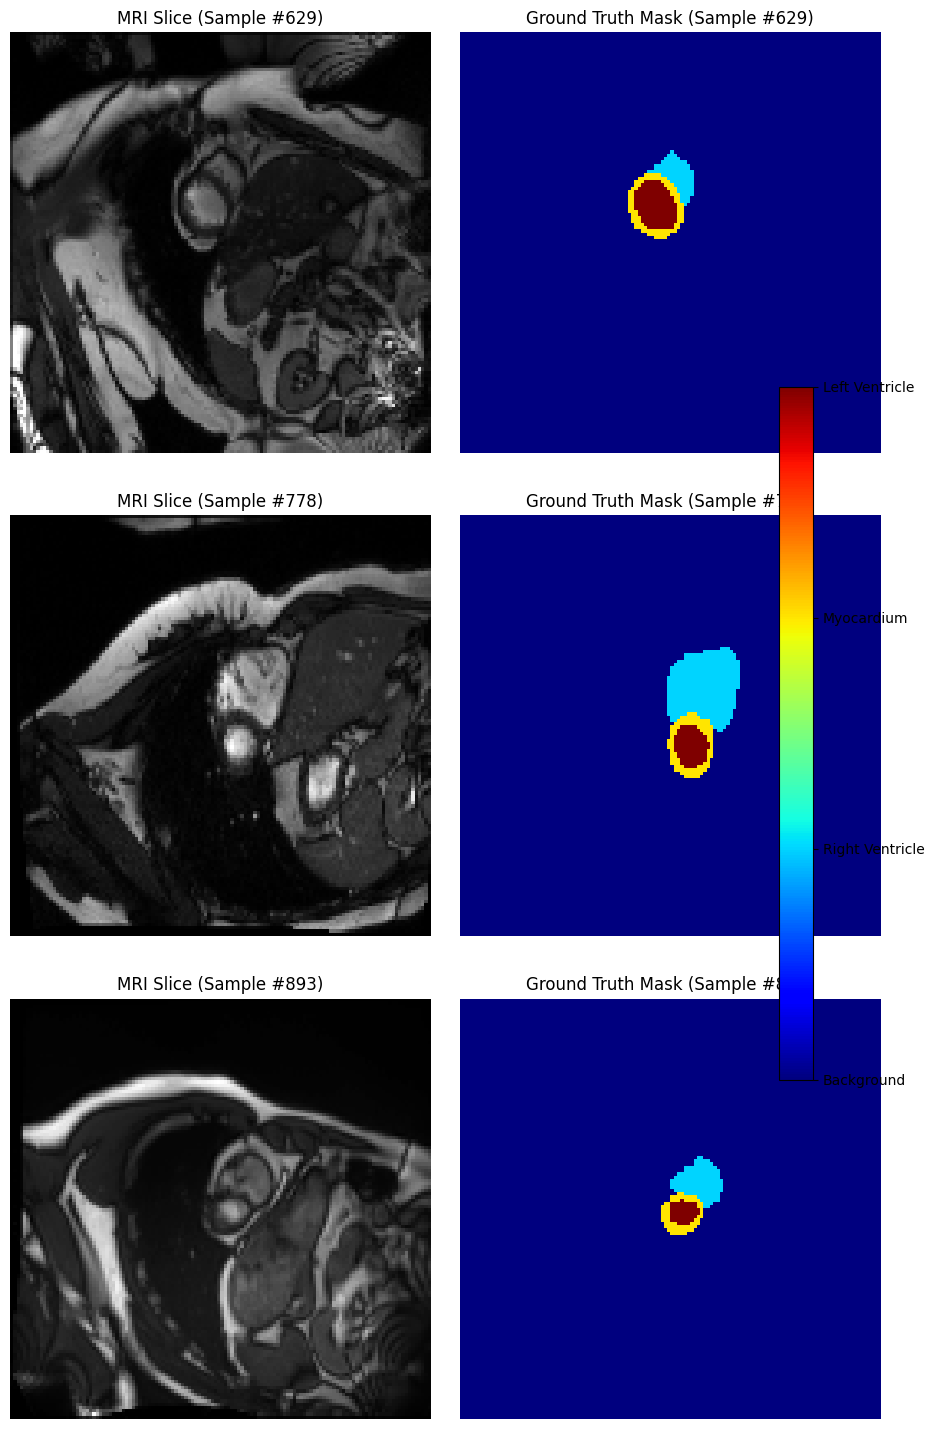

In [14]:
# ----------------------------
# VISUALIZE A FEW SAMPLES
# ----------------------------
def visualize_samples(X, Y, num_samples=5):
    """
    Visualizes a random selection of image-mask pairs.
    X: Numpy array of images
    Y: Numpy array of masks
    num_samples: Number of pairs to display
    """
    if X.shape[0] == 0:
        print("No data to visualize.")
        return
        
    # Ensure num_samples is not greater than the number of available slices
    num_samples = min(num_samples, X.shape[0])
    
    # Select random indices
    random_indices = np.random.choice(X.shape[0], num_samples, replace=False)
    
    # Define class labels for the title
    class_labels = {0: 'Background', 1: 'Right Ventricle', 2: 'Myocardium', 3: 'Left Ventricle'}

    # Create a figure to display the samples
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    
    # Adjust for case where num_samples=1, as axes will not be a 2D array
    if num_samples == 1:
        axes = [axes]

    for i, idx in enumerate(random_indices):
        # Display the MRI slice
        axes[i, 0].imshow(X[idx], cmap='gray')
        axes[i, 0].set_title(f"MRI Slice (Sample #{idx})")
        axes[i, 0].axis('off')
        
        # Display the corresponding ground truth mask
        mask_image = axes[i, 1].imshow(Y[idx], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title(f"Ground Truth Mask (Sample #{idx})")
        axes[i, 1].axis('off')

    # Add a colorbar to explain the mask colors
    cbar = fig.colorbar(mask_image, ax=axes, shrink=0.6, location='right', ticks=list(class_labels.keys()))
    cbar.ax.set_yticklabels(list(class_labels.values()))
    
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar
    plt.show()

# Call the function to visualize 3 random samples from your loaded data
visualize_samples(X_raw, Y_raw, num_samples=3)

In [15]:

# ----------------------------
# PREPROCESS FOR TRAINING
# ----------------------------
if X_raw.size == 0:
    raise ValueError("No data loaded. Check data_dir, file names, or MIN_FOREGROUND_PERCENTAGE.")

# Add channel dimension for grayscale images (N, H, W) -> (N, H, W, 1)
X_processed = X_raw[..., np.newaxis]

# Convert masks to categorical format (N, H, W) -> (N, H, W, C) for NUM_CLASSES
Y_processed_cat = tf.keras.utils.to_categorical(Y_raw, num_classes=NUM_CLASSES)

print(f"X_processed shape: {X_processed.shape}")
print(f"Y_processed_cat shape: {Y_processed_cat.shape}")

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_processed, Y_processed_cat, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")


X_processed shape: (933, 128, 128, 1)
Y_processed_cat shape: (933, 128, 128, 4)
X_train shape: (746, 128, 128, 1), Y_train shape: (746, 128, 128, 4)
X_val shape: (187, 128, 128, 1), Y_val shape: (187, 128, 128, 4)


In [16]:
# --- A MORE ROBUST WAY TO DO STRATIFIED SPLITTING ---

# 1. Create the representative labels (same as before)
slice_labels = []
for i in range(Y_raw.shape[0]):
    mask_slice = Y_raw[i]
    counts = np.bincount(mask_slice.flatten(), minlength=NUM_CLASSES)
    if np.sum(counts[1:]) > 0:
        dominant_class = np.argmax(counts[1:]) + 1
    else:
        dominant_class = 0
    slice_labels.append(dominant_class)
slice_labels = np.array(slice_labels)

# 2. Get the indices for the split
indices = np.arange(X_processed.shape[0])
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=slice_labels)

# 3. Create the datasets using the indices
X_train, Y_train = X_processed[train_indices], Y_processed_cat[train_indices]
X_val, Y_val = X_processed[val_indices], Y_processed_cat[val_indices]

# 4. Verification
print("--- Stratification Check ---")
print("Training set class distribution:\n", pd.Series(slice_labels[train_indices]).value_counts(normalize=True).sort_index())
print("\nValidation set class distribution:\n", pd.Series(slice_labels[val_indices]).value_counts(normalize=True).sort_index())

print(f"\nFinal X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"Final X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

--- Stratification Check ---
Training set class distribution:
 1    0.403485
2    0.198391
3    0.398123
Name: proportion, dtype: float64

Validation set class distribution:
 1    0.401070
2    0.197861
3    0.401070
Name: proportion, dtype: float64

Final X_train shape: (746, 128, 128, 1), Y_train shape: (746, 128, 128, 4)
Final X_val shape: (187, 128, 128, 1), Y_val shape: (187, 128, 128, 4)


In [17]:
# ----------------------------
# CLASS WEIGHTS (Median Frequency Balancing)
# ----------------------------
# Calculate class weights based on the training set
# First, convert Y_train from one-hot back to single integer labels to count occurrences
y_train_labels_flat = np.argmax(Y_train, axis=-1).flatten()

# Count occurrences of each class
class_counts = np.bincount(y_train_labels_flat, minlength=NUM_CLASSES)

# Calculate total pixels
# total_pixels = np.sum(class_counts) # Not directly used in this weighting scheme

# Median Frequency Balancing
# Calculate median of frequencies for classes that are present
median_freq = np.median(class_counts[class_counts > 0])

# Calculate weights: median_freq / count_for_class
# Add epsilon to prevent division by zero for classes potentially not in y_train_labels_flat (though minlength handles this)
class_weights_values = median_freq / (class_counts + 1e-6)

# Normalize weights (optional, but can sometimes help if loss magnitudes are an issue)
# class_weights_values = class_weights_values / np.sum(class_weights_values) * NUM_CLASSES

print("Class distribution in training set (pixels):")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} pixels")

print("\nCalculated class weights:")
for i, weight in enumerate(class_weights_values):
    print(f"Class {i}: {weight:.4f}")

# Store as a TF constant or dictionary for the loss function
# The loss function will expect a list or array of weights.
class_weights_tf = tf.constant(class_weights_values, dtype=tf.float32)

Class distribution in training set (pixels):
Class 0: 11681028 pixels
Class 1: 196526 pixels
Class 2: 146988 pixels
Class 3: 197922 pixels

Calculated class weights:
Class 0: 0.0169
Class 1: 1.0036
Class 2: 1.3418
Class 3: 0.9965


I0000 00:00:1751985384.891891      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751985384.892606      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [20]:
# ----------------------------
# LOSS FUNCTION
# ----------------------------
def combined_loss_builder(class_weights_tensor, num_classes):
    """
    Builds a combined loss function using weighted categorical cross-entropy and weighted Dice loss.
    Args:
        class_weights_tensor: A 1D TensorFlow tensor of weights for each class.
        num_classes: Total number of classes.
    Returns:
        A loss function.
    """
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon()) # Stability

        # --- Weighted Categorical Cross-Entropy ---
        # Element-wise multiplication of y_true by weights for the CE calculation
        # For each pixel, the loss for its true class is scaled by that class's weight.
        
        # Manual calculation of weighted CE:
        # ce_loss_unweighted = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        # weights_per_pixel = tf.reduce_sum(y_true * class_weights_tensor, axis=-1) # Get weight for the true class of each pixel
        # ce_loss = tf.reduce_mean(ce_loss_unweighted * weights_per_pixel)
        
        # Simpler: Using Keras's CCE and scaling the result per sample by sum of y_true*weights
        # This effectively weights each pixel's contribution based on its true class
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        # For each pixel, y_true is one-hot. y_true * class_weights_tensor will pick the weight of the true class.
        # Then sum these weights across the class dimension.
        pixel_weights = tf.reduce_sum(y_true * class_weights_tensor, axis=-1)
        weighted_cce = cce * pixel_weights
        ce_loss = tf.reduce_mean(weighted_cce)


        # --- Weighted Dice Loss ---
        smooth = 1e-6
        dice_loss_total = 0.0
        
        for i in range(num_classes):
            y_true_i = y_true[..., i]
            y_pred_i = y_pred[..., i]
            
            intersection_i = tf.reduce_sum(y_true_i * y_pred_i)
            union_i = tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i)
            
            dice_score_i = (2. * intersection_i + smooth) / (union_i + smooth)
            class_dice_loss_i = 1. - dice_score_i
            
            # Weight the Dice loss for this class
            dice_loss_total += class_weights_tensor[i] * class_dice_loss_i
            
        # Average the weighted Dice losses across classes (optional, could also sum)
        # If summing, the overall loss magnitude might be larger.
        # Here, we sum the weighted individual class dice losses.
        # The original code summed them, which is fine.
        
        return ce_loss + dice_loss_total # Total dice loss is already sum of weighted per-class dice losses
    
    loss.__name__ = 'custom_combined_loss' # Keras needs a name for custom objects
    return loss

# Instantiate the loss function with the calculated weights
custom_loss_fn = combined_loss_builder(class_weights_tf, NUM_CLASSES)

In [21]:
# ----------------------------
# IMPROVED U-NET MODEL
# ----------------------------
def improved_unet(input_shape=(128, 128, 1), num_classes=4):
    inputs = tf.keras.Input(input_shape)
    
    # Standard convolutional block: Conv -> BN -> ReLU -> Dropout -> Conv -> BN -> ReLU
    def conv_block(x, filters, dropout_rate=0.1, kernel_size=3):
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        # Dropout is often placed after activation
        if dropout_rate > 0:
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
            
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        return x
    
    # Encoder block: conv_block -> MaxPooling
    def encoder_block(x, filters, dropout_rate=0.1):
        f = conv_block(x, filters, dropout_rate=dropout_rate)
        p = tf.keras.layers.MaxPooling2D((2, 2))(f)
        return f, p # Return features before pooling for skip connection
    
    # Decoder block: Conv2DTranspose -> Concatenate (skip) -> conv_block
    def decoder_block(x, skip_features, filters, dropout_rate=0.1):
        x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
        x = tf.keras.layers.concatenate([x, skip_features])
        x = conv_block(x, filters, dropout_rate=dropout_rate)
        return x
    
    # Encoder Path
    s1, p1 = encoder_block(inputs, 64, dropout_rate=0.1)       # 128 -> 64
    s2, p2 = encoder_block(p1, 128, dropout_rate=0.1)        # 64 -> 32
    s3, p3 = encoder_block(p2, 256, dropout_rate=0.2)        # 32 -> 16
    s4, p4 = encoder_block(p3, 512, dropout_rate=0.2)        # 16 -> 8

    # Bridge (Bottleneck)
    # Increased dropout here as it processes the most abstract features
    b1 = conv_block(p4, 1024, dropout_rate=0.3)              # 8x8x1024

    # Decoder Path
    d1 = decoder_block(b1, s4, 512, dropout_rate=0.2)        # 8 -> 16
    d2 = decoder_block(d1, s3, 256, dropout_rate=0.2)        # 16 -> 32
    d3 = decoder_block(d2, s2, 128, dropout_rate=0.1)        # 32 -> 64
    d4 = decoder_block(d3, s1, 64, dropout_rate=0.1)         # 64 -> 128

    # Output Layer
    # 1x1 Convolution to map feature channels to num_classes
    # Softmax activation for multi-class segmentation (pixel-wise probabilities)
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(d4)

    model = tf.keras.Model(inputs, outputs, name="improved_unet")
    return model

# Instantiate the model
model = improved_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), num_classes=NUM_CLASSES)
model.summary()

Model: "improved_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)       

 Total params: 31,054,340 (118.46 MB)

 Trainable params: 31,042,564 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [22]:
# ----------------------------
# DATA AUGMENTATION
# ----------------------------
# Create two instances with the same arguments for image and mask
# Ensure the same seed is used for both generators if flowing separately,
# or flow them together using datagen.flow(X_train, Y_train, ...)

image_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05, # Added small shear
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant', # Fills points outside boundaries with 0
    cval=0 # Value used for fill_mode='constant'
)

# For masks, we typically don't want intensity shifts or certain complex augmentations
# that might corrupt labels if not handled carefully.
# However, geometric transformations must be identical to the image.
# Keras's flow(X, y) applies the same *geometric* transformations to X and y.
# For pixel-value based augmentations in image_datagen, they won't apply to Y_train if Y_train is label data.

# The ImageDataGenerator will be used with model.fit's generator input.
# It's generally recommended to fit the generator on the training data if using
# featurewise_center, featurewise_std_normalization, or zca_whitening,
# but for these geometric augmentations, it's not strictly necessary.
# image_datagen.fit(X_train) # Not strictly needed for these augmentations

In [23]:
# ----------------------------
# COMPILE MODEL AND DEFINE CALLBACKS
# ----------------------------

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # A common starting learning rate

# Metrics
# Note: Keras MeanIoU name can be tricky with tf.keras.metrics.MeanIoU.
# We'll use a string name and Keras should find it.
# Or define it explicitly and pass the object.
metrics_to_track = [
    tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name="mean_io_u"),
    # Recall for each foreground class
    tf.keras.metrics.Recall(class_id=1, name='recall_RV'), # RV: Right Ventricle
    tf.keras.metrics.Recall(class_id=2, name='recall_MYO'),# MYO: Myocardium
    tf.keras.metrics.Recall(class_id=3, name='recall_LV')  # LV: Left Ventricle
]

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=custom_loss_fn, # Our custom combined loss
    metrics=metrics_to_track
)

# Callbacks
# ModelCheckpoint: Save the best model based on validation MeanIoU
checkpoint_filepath = 'best_heart_segmentation_model.keras' # Use .keras for modern TF
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save entire model
    monitor='val_mean_io_u', # Monitor validation Mean IoU
    mode='max', # We want to maximize Mean IoU
    save_best_only=True, # Only save if it's an improvement
    verbose=1)

# EarlyStopping: Stop training if validation MeanIoU doesn't improve
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    patience=15, # Number of epochs with no improvement after which training will be stopped
    mode='max',
    verbose=1,
    restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_io_u',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6, # Lower bound on the learning rate.
    mode='max',
    verbose=1)

callbacks_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [24]:
# ----------------------------
# TRAIN THE MODEL
# ----------------------------

# Create the training data generator
# Y_train is already one-hot encoded
train_generator = image_datagen.flow(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE
)

# Calculate steps_per_epoch
# If X_train is small, ensure steps_per_epoch is at least 1
steps_per_epoch = max(1, len(X_train) // BATCH_SIZE)

print(f"Starting training with {EPOCHS} epochs, batch size {BATCH_SIZE}, steps per epoch {steps_per_epoch}.")
print(f"Training data shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Validation data shape: X_val: {X_val.shape}, Y_val: {Y_val.shape}")


if X_val.size == 0 or Y_val.size == 0:
    print("Warning: Validation data is empty. Skipping validation during training.")
    validation_data_tuple = None
    # If you must run without validation (not recommended for final model):
    # history = model.fit(
    #     train_generator,
    #     epochs=EPOCHS,
    #     steps_per_epoch=steps_per_epoch,
    #     callbacks=callbacks_list, # Callbacks might still use 'val_loss' etc. by default if not careful
    #     verbose=1
    # )
    # Better to raise an error or ensure validation data is present.
    raise ValueError("Validation data is empty. Cannot proceed with training that relies on validation metrics.")

else:
    validation_data_tuple = (X_val, Y_val)
    history = model.fit(
        train_generator,
        validation_data=validation_data_tuple,
        epochs=EPOCHS, # Max epochs; EarlyStopping will likely stop it sooner
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks_list,
        verbose=1 # Or 2 for less output per epoch
    )

print("Training finished.")
# The best model is saved as 'best_heart_segmentation_model.keras' due to ModelCheckpoint
# and EarlyStopping (with restore_best_weights=True) ensures 'model' has these best weights.

Starting training with 100 epochs, batch size 8, steps per epoch 93.
Training data shape: X_train: (746, 128, 128, 1), Y_train: (746, 128, 128, 4)
Validation data shape: X_val: (187, 128, 128, 1), Y_val: (187, 128, 128, 4)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751985441.784229      98 service.cc:148] XLA service 0x7e112c003b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751985441.785705      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751985441.785731      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751985443.695591      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751985473.535032      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

76/93 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 3.3166 - mean_io_u: 0.3604 - recall_LV: 0.1634 - recall_MYO: 0.1552 - recall_RV: 0.1618

E0000 00:00:1751985492.727077      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751985492.945895      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 3.3014 - mean_io_u: 0.3496 - recall_LV: 0.1865 - recall_MYO: 0.1601 - recall_RV: 0.1952
Epoch 1: val_mean_io_u improved from -inf to 0.37500, saving model to best_heart_segmentation_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 124s 788ms/step - loss: 3.3003 - mean_io_u: 0.3490 - recall_LV: 0.1879 - recall_MYO: 0.1604 - recall_RV: 0.1971 - val_loss: 3.3511 - val_mean_io_u: 0.3750 - val_recall_LV: 0.0000e+00 - val_recall_MYO: 0.0000e+00 - val_recall_RV: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - loss: 2.9203 - mean_io_u: 0.3750 - recall_LV: 0.4744 - recall_MYO: 0.3985 - recall_RV: 0.6368

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_mean_io_u did not improve from 0.37500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9203 - mean_io_u: 0.3750 - recall_LV: 0.4744 - recall_MYO: 0.3985 - recall_RV: 0.6368 - val_loss: 3.3549 - val_mean_io_u: 0.3750 - val_recall_LV: 0.0000e+00 - val_recall_MYO: 0.0000e+00 - val_recall_RV: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.7638 - mean_io_u: 0.3498 - recall_LV: 0.6269 - recall_MYO: 0.2836 - recall_RV: 0.6006
Epoch 3: val_mean_io_u did not improve from 0.37500
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - loss: 2.7630 - mean_io_u: 0.3492 - recall_LV: 0.6268 - recall_MYO: 0.2842 - recall_RV: 0.6002 - val_loss: 3.4021 - val_mean_io_u: 0.3750 - val_recall_LV: 0.0000e+00 - val_recall_MYO: 0.1565 - val_recall_RV: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - loss: 2.3595 - mean_io_u: 0.3750 - recall_LV: 0.6262 - recall_MYO: 0.3840 - recall_RV: 0.7358
Epoch 4: val_m

In [25]:
# ----------------------------
# (OPTIONAL) LOAD BEST MODEL AND EVALUATE
# ----------------------------
# If EarlyStopping(restore_best_weights=True) was used, the 'model' object
# in memory already has the best weights.
# If not, or if you want to load explicitly from the saved file:
print(f"Loading best model from: {checkpoint_filepath}")
best_model = tf.keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'custom_combined_loss': custom_loss_fn} # Crucial for custom loss
)
# Note: If your custom loss function was defined as a class that inherits from tf.keras.losses.Loss,
# you might register it with @tf.keras.utils.register_keras_serializable or pass it via custom_objects.
# For a simple function like ours, passing via custom_objects is usually sufficient.

print("\nEvaluating the best model on the validation set:")
if X_val.size > 0:
    val_loss, val_mean_iou, val_recall_rv, val_recall_myo, val_recall_lv = best_model.evaluate(
        X_val, Y_val, verbose=1
    )
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Mean IoU: {val_mean_iou:.4f}")
    print(f"Validation RV Recall: {val_recall_rv:.4f}")
    print(f"Validation MYO Recall: {val_recall_myo:.4f}")
    print(f"Validation LV Recall: {val_recall_lv:.4f}")
else:
    print("Skipping evaluation as validation data is empty.")

# You can also evaluate on the test set if you have one (ensure same preprocessing)
# test_loss, test_mean_iou, ... = best_model.evaluate(X_test, Y_test_cat, verbose=1)

Loading best model from: best_heart_segmentation_model.keras

Evaluating the best model on the validation set:
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - loss: 2.3369 - mean_io_u: 0.3752 - recall_LV: 0.4326 - recall_MYO: 0.5175 - recall_RV: 0.6464
Validation Loss: 2.3366
Validation Mean IoU: 0.3752
Validation RV Recall: 0.6352
Validation MYO Recall: 0.5336
Validation LV Recall: 0.4386


In [ ]:
print(predicted_mask.shape)
print(true_mask.shape)
print(np.unique(predicted_mask))
print(np.unique(true_mask))

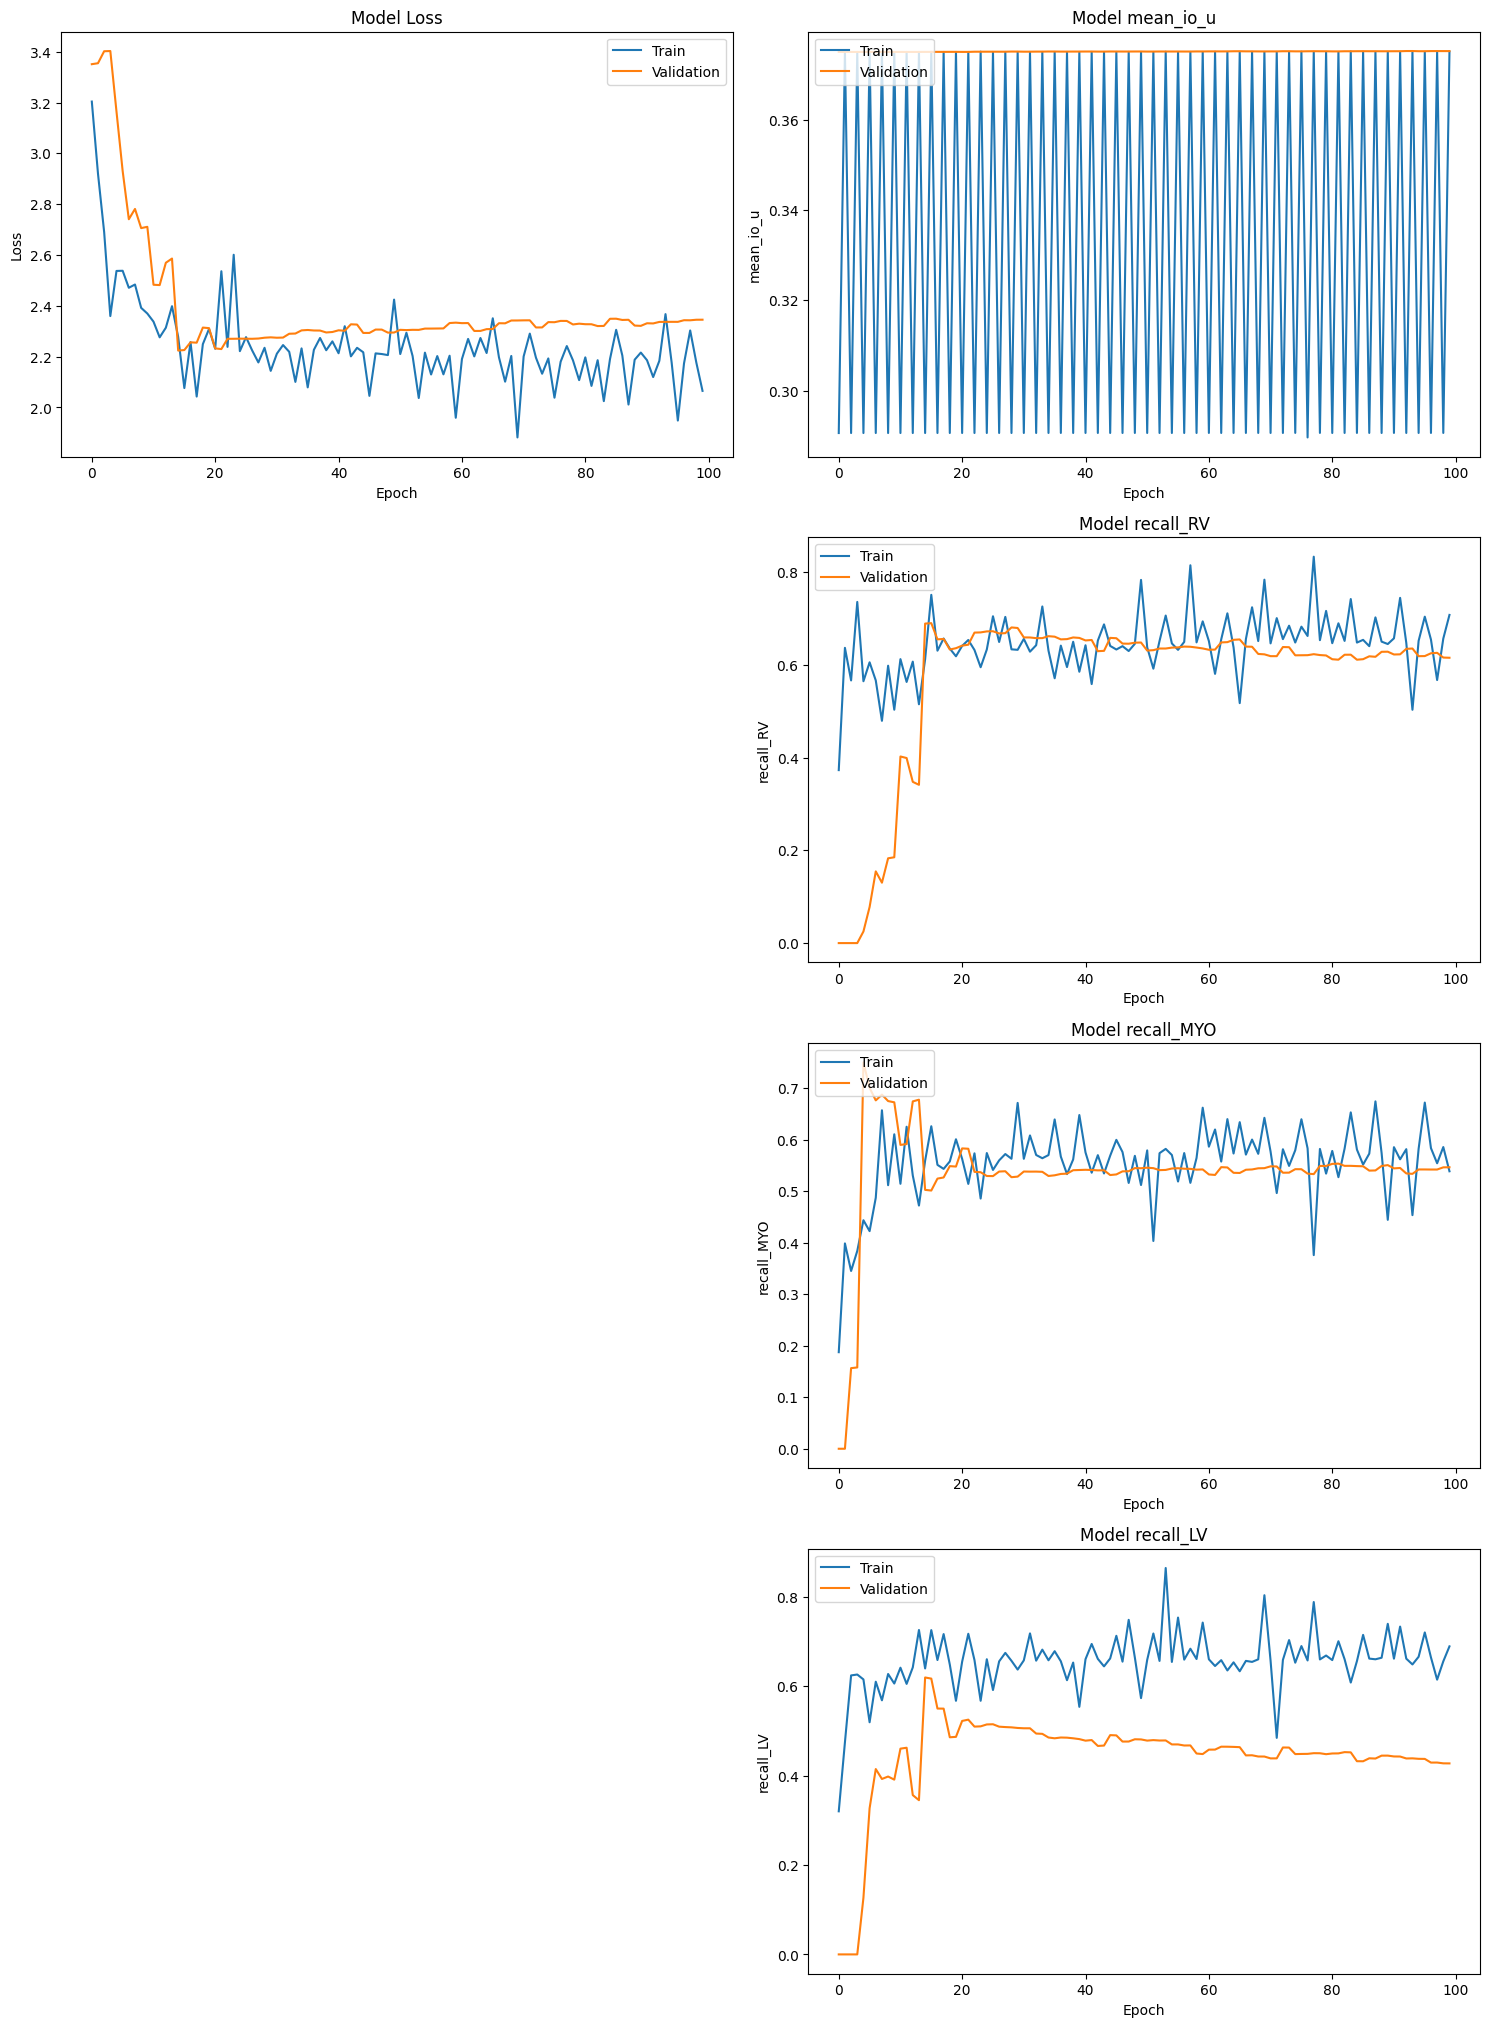

In [26]:
# ----------------------------
# PLOT TRAINING HISTORY
# ----------------------------
def plot_training_history(training_history, metrics_to_plot):
    plt.figure(figsize=(15, 5 * len(metrics_to_plot)))
    
    # Plot training & validation loss values
    plt.subplot(len(metrics_to_plot), 2, 1) # Adjusted for multiple metric rows
    if 'loss' in training_history.history:
        plt.plot(training_history.history['loss'])
    if 'val_loss' in training_history.history:
        plt.plot(training_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot other specified metrics
    plot_idx = 2
    for metric_name in metrics_to_plot:
        if metric_name == 'loss': continue # Already plotted

        plt.subplot(len(metrics_to_plot), 2, plot_idx)
        if metric_name in training_history.history:
            plt.plot(training_history.history[metric_name])
        if f'val_{metric_name}' in training_history.history:
            plt.plot(training_history.history[f'val_{metric_name}'])
        plt.title(f'Model {metric_name}')
        plt.ylabel(metric_name)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plot_idx +=1
        if plot_idx % 2 == 1 and plot_idx > 1: # Move to next row after 2 plots if needed
            plot_idx +=1


    plt.tight_layout()
    plt.show()

# Extract the names of the metrics we tracked (excluding the 'val_' prefix for base name)
# history.history.keys() will give e.g. ['loss', 'mean_io_u', 'recall_RV', ..., 'val_loss', 'val_mean_io_u', ...]
tracked_metric_names = [m.name for m in metrics_to_track] # e.g., ['mean_io_u', 'recall_RV', ...]
# Add 'loss' if it's not already somehow in a metric object's name
if 'loss' not in tracked_metric_names:
    plot_metric_list = ['loss'] + tracked_metric_names
else:
    plot_metric_list = tracked_metric_names

if 'history' in locals() and history is not None: # Check if history object exists
    plot_training_history(history, plot_metric_list)
else:
    print("Training history not available for plotting.")

Visualizing Training Samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


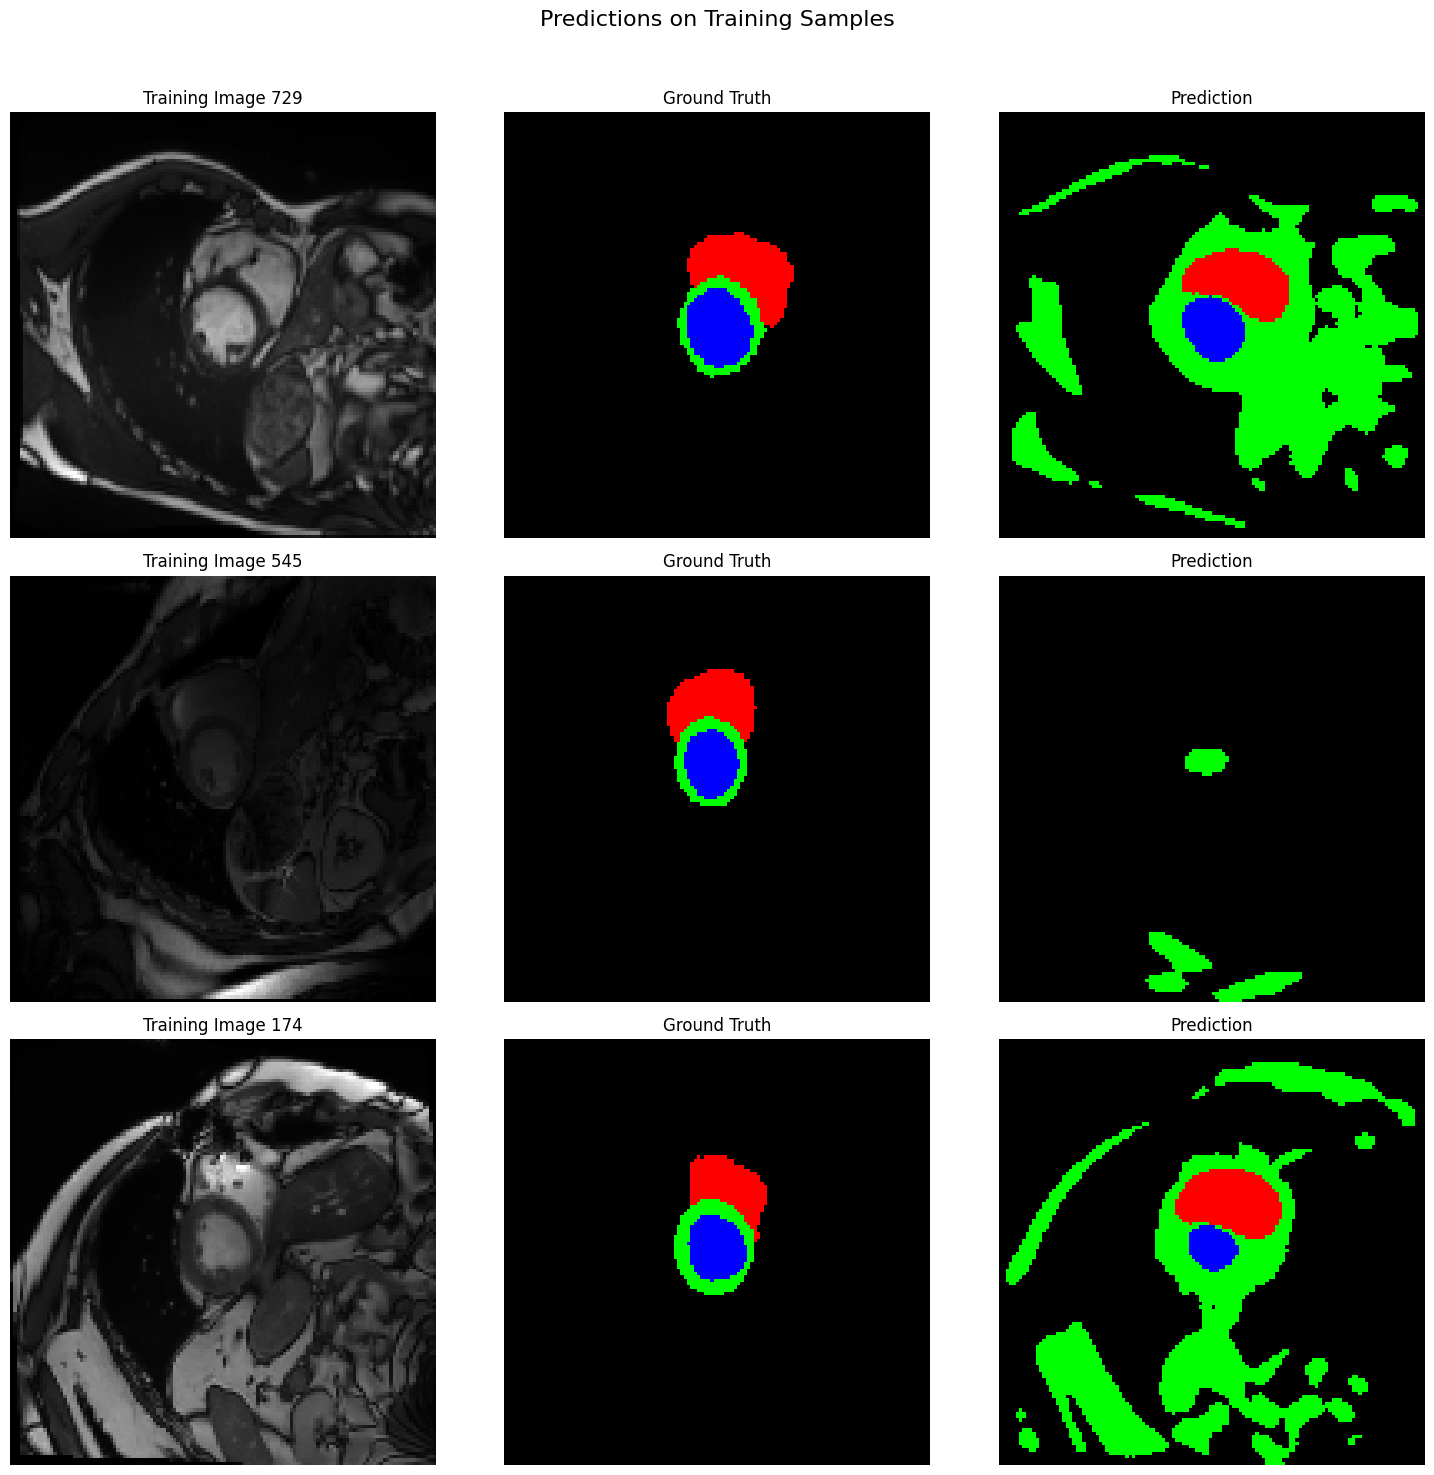


Visualizing Validation Samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


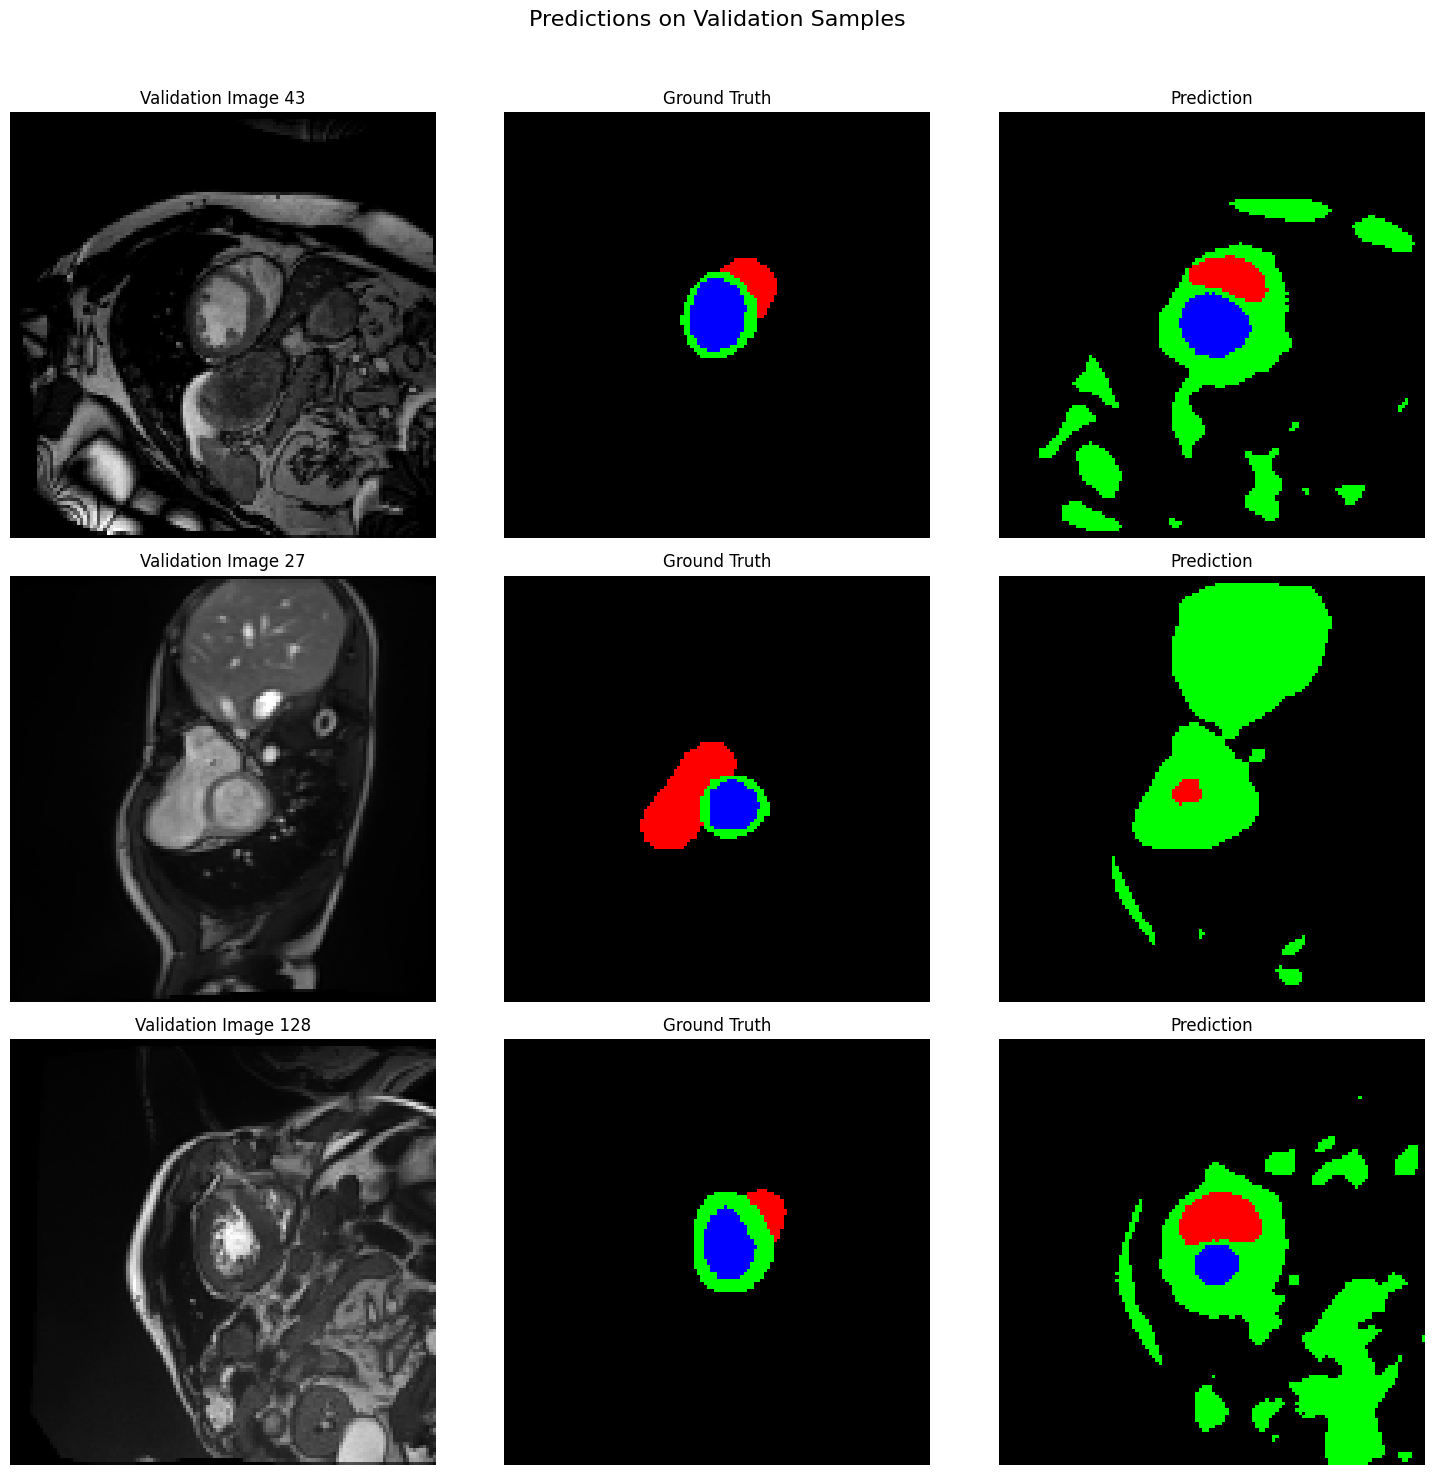

In [27]:
# ----------------------------
# VISUALIZE PREDICTIONS
# ----------------------------
def visualize_predictions(model_to_eval, X_data, y_true_cat, num_samples=5, dataset_name="Dataset"):
    if len(X_data) == 0:
        print(f"No data in {dataset_name} to visualize.")
        return

    indices = np.random.choice(len(X_data), min(num_samples, len(X_data)), replace=False)
    sample_images = X_data[indices]
    sample_masks_one_hot = y_true_cat[indices] # True masks are one-hot encoded
    
    # Predict: model output is (batch, H, W, C) with probabilities
    pred_masks_one_hot = model_to_eval.predict(sample_images)
    # Convert predictions and true masks from one-hot to label encoding (H, W)
    pred_masks_labels = np.argmax(pred_masks_one_hot, axis=-1)
    true_masks_labels = np.argmax(sample_masks_one_hot, axis=-1) 
    
    # Class-color mapping (ensure NUM_CLASSES matches)
    class_colors = {
        0: [0, 0, 0],      # Background - Black
        1: [255, 0, 0],    # Class 1 (RV) - Red
        2: [0, 255, 0],    # Class 2 (MYO) - Green
        3: [0, 0, 255]     # Class 3 (LV) - Blue
        # Add more if NUM_CLASSES > 4
    }
    
    plt.figure(figsize=(15, 5 * min(num_samples, len(X_data))))
    
    for i in range(min(num_samples, len(X_data))):
        # Original Image (remove channel dim for display)
        plt.subplot(min(num_samples, len(X_data)), 3, i * 3 + 1)
        plt.imshow(sample_images[i].squeeze(), cmap='gray')
        plt.title(f"{dataset_name} Image {indices[i]}")
        plt.axis('off')
        
        # Ground Truth Mask (convert label mask to RGB)
        plt.subplot(min(num_samples, len(X_data)), 3, i * 3 + 2)
        rgb_true_mask = np.zeros((*true_masks_labels[i].shape, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            if class_idx < NUM_CLASSES: # Ensure class_idx is valid
                 rgb_true_mask[true_masks_labels[i] == class_idx] = color
        plt.imshow(rgb_true_mask)
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask (convert label mask to RGB)
        plt.subplot(min(num_samples, len(X_data)), 3, i * 3 + 3)
        rgb_pred_mask = np.zeros((*pred_masks_labels[i].shape, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            if class_idx < NUM_CLASSES: # Ensure class_idx is valid
                rgb_pred_mask[pred_masks_labels[i] == class_idx] = color
        plt.imshow(rgb_pred_mask)
        plt.title("Prediction")
        plt.axis('off')
    
    plt.suptitle(f"Predictions on {dataset_name} Samples", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

# Load the best model if not already loaded or if 'model' doesn't have best weights
# (Assuming 'best_model' was loaded in Cell 11 or 'model' has best weights from EarlyStopping)
model_for_viz = best_model # Or 'model' if EarlyStopping restored best weights

# Visualize on a few training samples
if X_train.size > 0:
    print("Visualizing Training Samples:")
    visualize_predictions(model_for_viz, X_train, Y_train, num_samples=3, dataset_name="Training")

# Visualize on a few validation samples
if X_val.size > 0:
    print("\nVisualizing Validation Samples:")
    visualize_predictions(model_for_viz, X_val, Y_val, num_samples=3, dataset_name="Validation")

In [ ]:
# ----------------------------
# LOSS FUNCTION
# ----------------------------
def combined_loss(class_weights):
    def loss(y_true, y_pred):
        # Weighted Cross-Entropy
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        ce_loss = tf.reduce_mean(ce_loss * tf.reduce_sum(y_true * class_weights, axis=-1))
        
        # Weighted Dice Loss
        smooth = 1e-6
        dice_loss = 0.0
        for i in range(NUM_CLASSES):
            y_t = y_true[..., i]
            y_p = y_pred[..., i]
            inter = tf.reduce_sum(y_t * y_p)
            union = tf.reduce_sum(y_t + y_p)
            dice = (2. * inter + smooth) / (union + smooth)
            dice_loss += class_weights[i] * (1 - dice)
        
        return ce_loss + dice_loss
    return loss

# ----------------------------
# IMPROVED U-NET MODEL
# ----------------------------
def improved_unet(input_shape=(128, 128, 1), num_classes=4):
    inputs = tf.keras.Input(input_shape)
    
    def conv_block(x, filters, dropout_rate=0.1):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        return x
    
    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = tf.keras.layers.MaxPooling2D((2, 2))(f)
        return f, p
    
    def decoder_block(x, skip, filters):
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024, dropout_rate=0.2)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(d4)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# ----------------------------
# DATA AUGMENTATION
# ----------------------------
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant'
)

# ----------------------------
# COMPILE AND TRAIN
# ----------------------------
model = improved_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss(class_weights),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES),
        tf.keras.metrics.Recall(class_id=1, name='recall_class1'),
        tf.keras.metrics.Recall(class_id=2, name='recall_class2'),
        tf.keras.metrics.Recall(class_id=3, name='recall_class3')
    ]
)

In [ ]:
# Train with data augmentation
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=8),
    validation_data=(X_val, Y_val),
    epochs=50,
    steps_per_epoch=len(X_train)//8
)

In [ ]:
# ----------------------------
# EVALUATION
# ----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot class-specific recall
    plt.subplot(1, 2, 2)
    for metric in ['recall_class1', 'recall_class2', 'recall_class3']:
        if metric in history.history:
            plt.plot(history.history[metric])
    plt.title('Class Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Class 1', 'Class 2', 'Class 3'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, X, y_true, num_samples=5):
    # Get random samples
    indices = np.random.choice(len(X), num_samples, replace=False)
    sample_images = X[indices]
    sample_masks = y_true[indices]
    
    # Predict
    pred_masks = model.predict(sample_images)
    pred_masks = np.argmax(pred_masks, axis=-1)
    true_masks = np.argmax(sample_masks, axis=-1)
    
    # Create class-color mapping (modify colors as needed)
    class_colors = {
        0: [0, 0, 0],      # Background - Black
        1: [255, 0, 0],    # Class 1 - Red
        2: [0, 255, 0],     # Class 2 - Green
        3: [0, 0, 255]     # Class 3 - Blue
    }
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(sample_images[i].squeeze(), cmap='gray')
        plt.title(f"Image {indices[i]}")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(num_samples, 3, i*3 + 2)
        rgb_mask = np.zeros((*true_masks[i].shape, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            rgb_mask[true_masks[i] == class_idx] = color
        plt.imshow(rgb_mask)
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        rgb_pred = np.zeros((*pred_masks[i].shape, 3), dtype=np.uint8)
        for class_idx, color in class_colors.items():
            rgb_pred[pred_masks[i] == class_idx] = color
        plt.imshow(rgb_pred)
        plt.title("Prediction")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training samples:")
visualize_predictions(model, X_train, Y_train, num_samples=3)

# Visualize validation samples
print("\nValidation samples:")
visualize_predictions(model, X_val, Y_val, num_samples=3)

# Additional detailed view for one sample
def detailed_prediction_view(model, X, y_true, index):
    image = X[index]
    true_mask = np.argmax(y_true[index], axis=-1)
    
    # Predict
    pred_mask = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.argmax(pred_mask.squeeze(), axis=-1)
    
    # Create overlays
    class_colors = {
        0: [0, 0, 0, 0],      # Transparent
        1: [255, 0, 0, 100],  # Red with transparency
        2: [0, 255, 0, 100],  # Green with transparency
        3: [0, 0, 255, 100]    # Blue with transparency
    }
    
    # Create RGBA masks
    true_rgba = np.zeros((*true_mask.shape, 4), dtype=np.uint8)
    pred_rgba = np.zeros((*pred_mask.shape, 4), dtype=np.uint8)
    
    for class_idx, color in class_colors.items():
        true_rgba[true_mask == class_idx] = color
        pred_rgba[pred_mask == class_idx] = color
    
    plt.figure(figsize=(15, 10))
    
    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(2, 2, 2)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(true_rgba)
    plt.title("Ground Truth Overlay")
    plt.axis('off')
    
    # Prediction
    plt.subplot(2, 2, 3)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(pred_rgba)
    plt.title("Prediction Overlay")
    plt.axis('off')
    
    # Difference
    plt.subplot(2, 2, 4)
    difference = np.zeros((*pred_mask.shape, 4), dtype=np.uint8)
    correct = (true_mask == pred_mask) & (true_mask != 0)  # Ignore background
    false_pos = (true_mask == 0) & (pred_mask != 0)
    false_neg = (true_mask != 0) & (pred_mask == 0)
    
    difference[correct] = [0, 255, 0, 100]    # Green for correct
    difference[false_pos] = [255, 255, 0, 100] # Yellow for false positive
    difference[false_neg] = [255, 0, 0, 100]  # Red for false negative
    
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(difference)
    plt.title("Difference (Green=Correct, Yellow=FP, Red=FN)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show detailed view for a specific sample
detailed_prediction_view(model, X_val, Y_val, index=0)